In [1]:
import sys
import os
from imageio import imread
from PIL import Image
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import math 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools
import os
from imageio import imread
from PIL import Image
from glob import glob
import json
import platform

from skimage import io

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import timeit
import time

**Define some constants:**

In [3]:
IMG_W = 224  # image width
IMG_H = 224  # image height

B = 128 # batch size
NUM_CLASSES = 6 # number of classes

EPOCHS = 100

HIJACKED_MODEL = 'ResNet18'
CSV_FILE = 'imputed_unk_one_hot.csv'

HYBRID_STATUS_IMG_ONLY = 1
HYBRID_STATUS_TAB_ONLY = 2
HYBRID_STATUS_IMG_TAB = 3

IMG_ONLY_CHECK_POINT_FILE = 'hybrid_resnet18_img_only_final_checkpoint2.pt'
IMG_ONLY_BEST_STATE_FILE = 'hybrid_resnet18_img_only_best_model2.pt'

TAB_ONLY_CHECK_POINT_FILE = 'hybrid_resnet18_tab_only_final_checkpoint2.pt'
TAB_ONLY_BEST_STATE_FILE = 'hybrid_resnet18_tab_only_best_model2.pt'

IMG_TAB_CHECK_POINT_FILE = 'hybrid_resnet18_img_tab_final_checkpoint2.pt'
IMG_TAB_BEST_STATE_FILE = 'hybrid_resnet18_img_tab_best_model2.pt'

label_img_only = 'hybrid_resnet18_img_only'
label_tab_only = 'hybrid_resnet18_tab_only'
label_img_tab = 'hybrid_resnet18_img_tab'

cls_report_img_only_title = 'Classification Report of hybrid model ' + HIJACKED_MODEL + '(img only)'
cls_report_tab_only_title = 'Classification Report of hybrid model ' + HIJACKED_MODEL + '(tab only)'
cls_report_img_tab_title = 'Classification Report of hybrid model ' + HIJACKED_MODEL + '(img-tab combined)'

TABULAR_COLUMN_INDEX_RANGE = (0, 68)

**Display enviroment**

In [4]:
!nvidia-smi

Mon Dec  6 19:13:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
current_system = platform.system()

**Mount google drive:**

In [6]:
if 'Linux' == current_system:
  from google.colab import drive
  drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
#debug = True

In [8]:
debug = False

**Utility Functions**

In [9]:
def dump_list(file_name, a_list):
  file_full_path = os.path.join(project_root_path_string, file_name)
  with open(file_full_path, 'w') as fp:
    json.dump(a_list, fp)

In [10]:
def load_to_list(file_name):

  a_list = []
  file_full_path = os.path.join(project_root_path_string, file_name)
  with open(file_full_path, 'r') as fp:
    a_list = json.load(fp)

  return a_list

In [11]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [12]:
def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating!
        c, w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities 
        
        
        return y_hat.cpu().numpy().flatten()#convert prediction to numpy array. 

In [13]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [14]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        
        y_hat = model(inputs)
        
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

**Define a function that reload states to the given model and optimizer from the checkpoint file, and it also returns previously trained results and the latest epoch number:**

In [15]:
# reload the states to the given model and optimizer from the checkpoint file
def resume_states(checkpoint_file, model, optimizer, is_debug=False):
  del_opt = False
  results = {}
  last_epoch = -1

  if(checkpoint_file and os.path.isfile(checkpoint_file)):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])

    if(optimizer != None):
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
      #Create a default AdamW optimizer, then load state
      optimizer = torch.optim.AdamW(model.parameters())
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    results = checkpoint['results']
    last_epoch = checkpoint['epoch']

    if(is_debug):
      print('Loading checkpoint file:', checkpoint_file)
      print('last_epoch: ', last_epoch)
      print('results:', results)
      total_train_time = results["total time"][-1]
      print('total_train_time:', total_train_time)
      print('del_opt:', del_opt)
      print(model)
  
  if(optimizer==None):
    optimizer = torch.optim.AdamW(model.parameters())
    del_opt = True

  return model, optimizer, last_epoch, results, del_opt

In [16]:
def train_dl_model(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, best_model_state_file=None,
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    checkpoint_file -- the file saves the training status, so next invocation of the function can pick up what was left.
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    results = {}
    last_epoch = -1
    delete_opt = True
    total_train_time = 0.0 #How long have we spent in the training loop?
    the_optimizer = optimizer
    the_model = model

    ############################################################################################################################
    ###### Attempt to resume previous training states whenever a specified checkpoint file exists.
    ############################################################################################################################
    the_model, the_optimizer, last_epoch, results, delete_opt = resume_states(checkpoint_file, model, optimizer, is_debug=True)

    if(len(results)!=0):  
      total_train_time = results["total time"][-1]  # Restore the latest total training time 

    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
     
    if(len(results)==0):
      #Initialize every item with an empty list
      for item in to_track:
        results[item] = []

    del_opt = delete_opt

    #Place the model on the correct compute resource (CPU or GPU)
    the_model.to(device)

    if(last_epoch==-1):  #No last_epoch is found in checkpoint file, so it indicates training starts from brand new and not from resumed state
      start_epoch = 0
    else:
      start_epoch = last_epoch + 1

    for epoch in tqdm(range(start_epoch, epochs), desc="Epoch", disable=disable_tqdm):
        the_model = the_model.train()#Put our model in training mode

        total_train_time += run_epoch(the_model, the_optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            the_model = the_model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(the_model, the_optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            the_model = the_model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(the_model, the_optimizer, val_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': the_model.state_dict(),
                'optimizer_state_dict': the_optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
            
            save_best_model_state(results, best_model_state_file, epoch, the_model, the_optimizer)
    if del_opt:
        del the_optimizer

    return pd.DataFrame.from_dict(results)

In [17]:
def save_best_model_state(results, best_model_state_file, epoch, model, optimizer):

  print('epoch:', epoch)
  if len(results['val Accuracy']) > 1:

    best_model_state_dict = torch.load(best_model_state_file)
    
    latest_score = results['val Accuracy'][-1]
    best_score = best_model_state_dict['best_score']

    print('latest_score:', latest_score)
    print('best_score stored:', best_score)

    if latest_score > best_score:
      best_score = latest_score
      print('Save the best model with score', best_score)

      torch.save({
                'epoch': epoch,
                'best_score': best_score,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, best_model_state_file)
  elif len(results['val Accuracy']) == 1:

    best_score = results['val Accuracy'][-1]
    print('Save the very first model state with score', best_score)

    torch.save({
                'epoch': epoch,
                'best_score': best_score,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, best_model_state_file)

**Function to plot the confusion Matrix**

In [18]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Function that constructs and draws a confusion matrix of a given model with testing DataLoader:**

In [19]:
def construct_and_plot_confusion_matrix(model, class_labels, test_loader, model_name):
  preds = []
  truths = []
  
  model.eval()
  with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
            
        data_inputs = inputs
        
        if debug == True:
          print(data_inputs)

        pred = model(moveTo(data_inputs, device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        
        preds.extend(pred.ravel())
        truths.extend(labels.numpy().ravel())
  
  acc_score = accuracy_score(preds, truths)
  
  if debug==True:
    print("Accuracy: ", accuracy_score(preds, truths))
    print('preds:',preds)
    print('truth:',truths)
    print('class_labels:',list(class_labels))

  cm = confusion_matrix(truths, preds)
  cls_report = classification_report(truths, preds, labels=list(class_labels))
  plot_confusion_matrix(cm, class_labels, 'Confusion Matrix (' + model_name + ')')

  return cm, acc_score, cls_report

In [20]:
set_seed(42)

**Create project root path:**

In [21]:
if 'Linux' == current_system:
  project_root_path_string = '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/'
  saved_file_path = '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/Deep_Learning/Saved_Files/'
else:
  project_root_path_string = 'C:\\Users\\Yunpe\\Documents\\Data606\\Project\\Skin_Cancer_ML_DL\\Skin_Cancer_Analysis'
  saved_file_path = 'C:\\Users\\Yunpe\\Documents\\Data606\\Project\\Skin_Cancer_ML_DL\\Skin_Cancer_Analysis\\Deep_Learning\\Saved_Files'

print("project_root_path_string:", project_root_path_string)
print('saved_file_path:', saved_file_path)

project_root_path_string: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/
saved_file_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/Deep_Learning/Saved_Files/


In [22]:
sys.path.append(project_root_path_string)
sys.path.append(saved_file_path)

sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/',
 '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/Deep_Learning/Saved_Files/']

**Get the root data directory:**

In [23]:
data_root_path = os.path.join(project_root_path_string, 'data') 

print("data_root_path:", data_root_path)

data_root_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data


**Get raw image directory:**

In [24]:
raw_image_data_path =  os.path.join(data_root_path, 'raw_image_data') 
print("raw_image_data_path:", raw_image_data_path)

raw_image_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/raw_image_data


**Get the tabular data path:**

In [25]:
tabular_data_path = os.path.join(data_root_path, 'tabular_data') 

print("tabular_data_path:", tabular_data_path)

tabular_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/tabular_data


**Create the lesion type abbrevation and full name dictionary:**

In [26]:
lesion_type_dict = {
    'ACK': 'Actinic Keratosis',
    'BCC': 'Basal Cell Carcinoma',
    'MEL': 'Melanoma',
    'NEV': 'Nevus',
    'SCC': 'Squamous Cell Carcinoma',
    'SEK': 'Seborrheic Keratosis'
    
}

**Class label encoding:**

In [27]:
class_idx = {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

**Get the skin_categorires path:**

In [28]:
processed_image_data_path =  os.path.join(data_root_path, 'processed_image_data') 
print("processed_image_data_path:", processed_image_data_path)

skin_categories_path =  os.path.join(processed_image_data_path, 'skin_categories') 
print("skin_categories_path:", skin_categories_path)

processed_image_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/processed_image_data
skin_categories_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/processed_image_data/skin_categories


In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

**Construct a pandas dataframe dataset that combines image information and encoded categorical data:**

**Read csv file into a panda data frame:**

In [30]:
data_pd = pd.read_csv(os.path.join(tabular_data_path, CSV_FILE))

In [31]:
data_pd

,smoke_False,smoke_True,drink_False,drink_True,background_father_AUSTRIA,background_father_BRAZIL,background_father_CZECH,background_father_GERMANY,background_father_ISRAEL,background_father_ITALY,background_father_NETHERLANDS,background_father_POLAND,background_father_POMERANIA,background_father_PORTUGAL,background_father_SPAIN,background_mother_BRAZIL,background_mother_FRANCE,background_mother_GERMANY,background_mother_ITALY,background_mother_NETHERLANDS,background_mother_NORWAY,background_mother_POLAND,background_mother_POMERANIA,background_mother_PORTUGAL,background_mother_SPAIN,pesticide_False,pesticide_True,gender_FEMALE,gender_MALE,skin_cancer_history_False,skin_cancer_history_True,cancer_history_False,cancer_history_True,has_piped_water_False,has_piped_water_True,has_sewage_system_False,has_sewage_system_True,region_ABDOMEN,region_ARM,region_BACK,region_CHEST,region_EAR,region_FACE,region_FOOT,region_FOREARM,region_HAND,region_LIP,region_NECK,region_NOSE,region_SCALP,region_THIGH,itch_False,itch_True,grew_False,grew_True,hurt_False,hurt_True,changed_False,changed_True,bleed_False,bleed_True,elevation_False,elevation_True,biopsed_False,biopsed_True,age,fitspatrick,diameter_1,diameter_2,img_id,target
0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,8,2.26573,11.897055,8.852209,PAT_1516_1765_530.png,3
1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,55,3.00000,6.000000,5.000000,PAT_46_881_939.png,1
2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,77,2.26573,11.897055,8.852209,PAT_1545_1867_547.png,0
3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,75,2.26573,11.897055,8.852209,PAT_1989_4061_934.png,0
4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,79,1.00000,5.000000,5.000000,PAT_684_1302_588.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,73,2.26573,11.897055,8.852209,PAT_1708_3156_175.png,0
2294,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,0,1,55,3.00000,13.000000,12.000000,PAT_46_880_140.png,1
2295,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,74,2.26573,11.897055,8.852209,PAT_1343_1217_404.png,5
2296,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,58,3.00000,5.000000,4.000000,PAT_326_690_823.png,1


In [32]:
data_pd.columns

Index(['smoke_False', 'smoke_True', 'drink_False', 'drink_True',
       'background_father_AUSTRIA', 'background_father_BRAZIL',
       'background_father_CZECH', 'background_father_GERMANY',
       'background_father_ISRAEL', 'background_father_ITALY',
       'background_father_NETHERLANDS', 'background_father_POLAND',
       'background_father_POMERANIA', 'background_father_PORTUGAL',
       'background_father_SPAIN', 'background_mother_BRAZIL',
       'background_mother_FRANCE', 'background_mother_GERMANY',
       'background_mother_ITALY', 'background_mother_NETHERLANDS',
       'background_mother_NORWAY', 'background_mother_POLAND',
       'background_mother_POMERANIA', 'background_mother_PORTUGAL',
       'background_mother_SPAIN', 'pesticide_False', 'pesticide_True',
       'gender_FEMALE', 'gender_MALE', 'skin_cancer_history_False',
       'skin_cancer_history_True', 'cancer_history_False',
       'cancer_history_True', 'has_piped_water_False', 'has_piped_water_True',
       'h

**Define Image and Tabular Combined Dataset:**

In [33]:
debug=False

In [34]:
class SkinImageTabularDataset(Dataset):
        
    def __init__(self, data_frame, image_root_directory, tabular_column_range=TABULAR_COLUMN_INDEX_RANGE, 
                 convert_to_tensor=True, img_transform=None):
        """
        Construct a dataset containing encoded tabular data and image data.
        
        data_frame: panda data frame containing columns of encoded tabular data and image ids (image file names)
        image_root_directory: root directory path to the raw images
        tabular_column_range: index range of tabular columns 
        convert_to_tensor: should the images be converted to tensors?
        img_transform: image transformation function
        
        """
        
        super(SkinImageTabularDataset, self).__init__()
        
        self.data_frame = data_frame
        self.tabular_column_range = tabular_column_range
        self.image_root_directory = image_root_directory
        
        if img_transform==None:
            if convert_to_tensor == True:
                self.img_transform = transforms.Compose([transforms.Resize((IMG_H, IMG_W)), transforms.ToTensor()])
            else:
                self.img_transform = transforms.Compose([transforms.Resize((IMG_H, IMG_W))]) # Don't convert to tensor
        else:
            self.img_transform = img_transform

        
    def __getitem__(self, index):
        
        image_name = self.data_frame['img_id'].iloc[index]
        
        if debug==True:
            print(type(image_name))
        
        image_path = os.path.join(self.image_root_directory, image_name)
        
        if debug==True:
            print(image_path)
        
        image = Image.open(image_path).convert('RGB')  #Some image may have more than 3 channels (alpha channel for transparency)
        image_input= image 
        
        if debug==True:
            print(image_input)
        
        if debug==True:
            print(type(image))
        
        tabular_input = torch.tensor(self.data_frame.iloc[index, self.tabular_column_range[0]:self.tabular_column_range[1]+1], dtype=torch.float32)
        
        image_input = self.img_transform(image_input)
        
        

        target = torch.tensor(self.data_frame.iloc[index,-1], dtype=torch.long)  #last column is the target
        
        input_data = {'image_input': image_input, 'tabular_input': tabular_input}
        
        return input_data, target 

    def __len__(self):
        return len(self.data_frame)
    

**Demonstrate sample data in SkinImageTabularDataset:**

In [35]:
skin_image_tabular_dataset = SkinImageTabularDataset(data_frame=data_pd, image_root_directory=raw_image_data_path, 
                                                     convert_to_tensor=False)

In [36]:
skin_image_tabular_dataset[0]

({'image_input': <PIL.Image.Image image mode=RGB size=224x224 at 0x7FA91CA95450>,
  'tabular_input': tensor([ 1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,
           0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,
           0.0000,  8.0000,  2.2657, 11.8971,  8.8522])},
 tensor(3))

In [37]:
x, y = skin_image_tabular_dataset[0]

print(x['tabular_input'])

print(x['image_input'])

tensor([ 1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         0.0000,  8.0000,  2.2657, 11.8971,  8.8522])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FA91AA5F990>


In [38]:
TAB_COL_SIZE = x['tabular_input'].shape[0]

print(TAB_COL_SIZE)

69


In [39]:
x['tabular_input']

tensor([ 1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         0.0000,  8.0000,  2.2657, 11.8971,  8.8522])

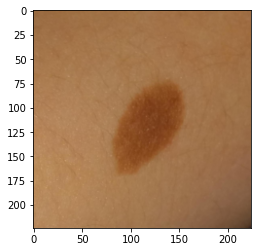

In [40]:
plt.imshow(x['image_input'])

In [41]:
target_code_dict = {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

**Split Training and Testing dataframe in stratify style:**

In [42]:
train_df, test_df = train_test_split(data_pd, test_size=0.2, stratify=data_pd['target'])

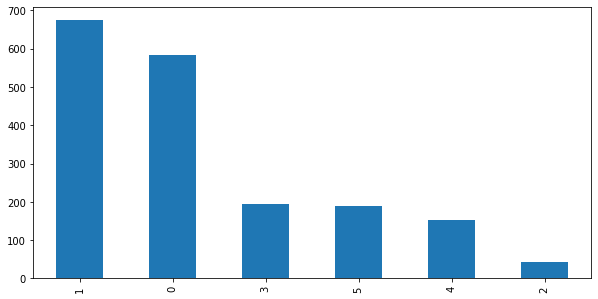

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
train_df['target'].value_counts().plot(kind='bar', ax=ax)

In [44]:
train_df['target'].value_counts()

1    676
0    584
3    195
5    188
4    153
2     42
Name: target, dtype: int64

In [45]:
test_df['target'].value_counts()

1    169
0    146
3     49
5     47
4     39
2     10
Name: target, dtype: int64

**Data augmentation and transformation:**

https://pytorch.org/vision/stable/transforms.html

In [46]:
def augment_data(skin_df, is_debug=False):
  
  # Get size of each group
  category_data_sizes = []
  for i in range(NUM_CLASSES):
    category_data_size = len(skin_df[skin_df['target'] == i])
    category_data_sizes.append(category_data_size)
  
  if(is_debug):
    print('category_data_sizes:', category_data_sizes)

  # Calculate the maximum size
  max_size = max(category_data_sizes)

  if(is_debug):
    print('max_size:', max_size)

  # Calculate augment ration between max size and the data size of each group
  for i in range(NUM_CLASSES): 
    data_category_df = skin_df[skin_df['target'] == i]
    augment_ratio = max_size // len(data_category_df)

    if(is_debug):
      print('augment_ratio:', augment_ratio)

    # Augment data in each small group
    for j in range(augment_ratio):
      if(augment_ratio > 1):  # don't do data augmentation for largest data category
        skin_df = skin_df.append(data_category_df, ignore_index=True)

  if(is_debug):
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    skin_df['target'].value_counts().plot(kind='bar', ax=ax)
  
  return skin_df

In [47]:
train_df = augment_data(train_df, is_debug=False)

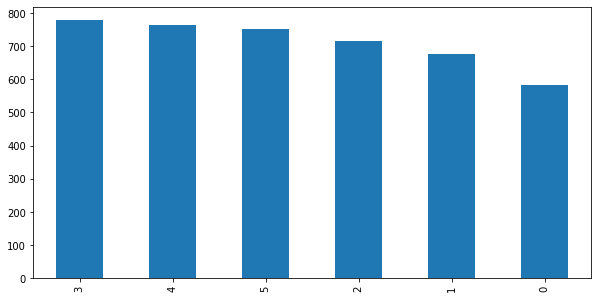

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
train_df['target'].value_counts().plot(kind='bar', ax=ax)

In [49]:
train_df

,smoke_False,smoke_True,drink_False,drink_True,background_father_AUSTRIA,background_father_BRAZIL,background_father_CZECH,background_father_GERMANY,background_father_ISRAEL,background_father_ITALY,background_father_NETHERLANDS,background_father_POLAND,background_father_POMERANIA,background_father_PORTUGAL,background_father_SPAIN,background_mother_BRAZIL,background_mother_FRANCE,background_mother_GERMANY,background_mother_ITALY,background_mother_NETHERLANDS,background_mother_NORWAY,background_mother_POLAND,background_mother_POMERANIA,background_mother_PORTUGAL,background_mother_SPAIN,pesticide_False,pesticide_True,gender_FEMALE,gender_MALE,skin_cancer_history_False,skin_cancer_history_True,cancer_history_False,cancer_history_True,has_piped_water_False,has_piped_water_True,has_sewage_system_False,has_sewage_system_True,region_ABDOMEN,region_ARM,region_BACK,region_CHEST,region_EAR,region_FACE,region_FOOT,region_FOREARM,region_HAND,region_LIP,region_NECK,region_NOSE,region_SCALP,region_THIGH,itch_False,itch_True,grew_False,grew_True,hurt_False,hurt_True,changed_False,changed_True,bleed_False,bleed_True,elevation_False,elevation_True,biopsed_False,biopsed_True,age,fitspatrick,diameter_1,diameter_2,img_id,target
0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,68,2.00000,10.000000,10.000000,PAT_735_1391_683.png,0
1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,53,2.26573,11.897055,8.852209,PAT_1722_3214_672.png,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,51,3.00000,9.000000,7.000000,PAT_730_1385_585.png,1
3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,40,2.26573,11.897055,8.852209,PAT_999_20_223.png,0
4,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,64,2.00000,5.000000,5.000000,PAT_625_1184_994.png,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,75,2.26573,11.897055,8.852209,PAT_1783_3414_120.png,5
4267,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,49,2.26573,11.897055,8.852209,PAT_1241_824_82.png,5
4268,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,67,2.26573,11.897055,8.852209,PAT_1455_1585_690.png,5
4269,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,57,2.26573,11.897055,8.852209,PAT_1072_318_856.png,5


In [50]:
transform_train = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop((IMG_H, IMG_W)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(25),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      #transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Transfer learning normalization requirements
                                    ])


transform_test = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop((IMG_H, IMG_W)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Transfer learning normalization requirements
                                    ])

**Create train_loader and test_loader:**

In [51]:
train_data = SkinImageTabularDataset(train_df, img_transform=transform_train, image_root_directory=raw_image_data_path)
test_data = SkinImageTabularDataset(test_df, img_transform=transform_test, image_root_directory=raw_image_data_path)

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B, shuffle=True)

In [52]:
train_data[0][0]['image_input'].shape

torch.Size([3, 224, 224])

**Define the Image and Tabular Combined Model:**

**A Hybrid Model architecture that can train image or tabular data or both:**

In [53]:
adaptive_neurons = 128
hidden_neurons = 512

In [54]:
class ImageTabularHybridModel(nn.Module):
    
    def __init__(self, hijacked_cnn_model_name='ResNet18', tabular_column_size=TAB_COL_SIZE, 
                 num_classes=NUM_CLASSES, hybrid_status=HYBRID_STATUS_IMG_TAB):
        
        super(ImageTabularHybridModel, self).__init__()
        
        self.hijacked_cnn_model_name = hijacked_cnn_model_name
        self.tabular_column_size = tabular_column_size
        self.num_classes = num_classes
        self.hybrid_status = hybrid_status
        
        #############################################################################
        ####  Define common building blockes of model architecture. 
        #############################################################################
        
        hijacked_model = None
        hijacked_model_last_layer_in_features = 512
        
        if hijacked_cnn_model_name=='ResNet18':
            hijacked_model = torchvision.models.resnet18(pretrained=True)
            hijacked_model_last_layer_in_features = hijacked_model.fc.in_features
        elif hijacked_cnn_model_name=='DenseNet121':
            hijacked_model = torchvision.models.densenet121(pretrained=True)
            hijacked_model_last_layer_in_features = hijacked_model.classifier.in_features
        elif hijacked_cnn_model_name=='GoogleNet':
            hijacked_model = torchvision.models.googlenet(pretrained=True)
            hijacked_model_last_layer_in_features = hijacked_model.fc.in_features
        elif hijacked_cnn_model_name=='MobileNet_v2':
            hijacked_model = torchvision.models.mobilenet_v2(pretrained=True)
            hijacked_model_last_layer_in_features = hijacked_model.last_channel
        
        tabular_linear_relu_stack = nn.Sequential(
                                    nn.Linear(tabular_column_size, hidden_neurons),
                                    nn.ReLU(),
                                    nn.Linear(hidden_neurons, hidden_neurons),
                                    nn.ReLU(),
                                    nn.Linear(hidden_neurons, adaptive_neurons),
                                    nn.ReLU())
        
        image_linear_relu_stack = nn.Sequential(
                                    nn.Linear(adaptive_neurons, hidden_neurons),
                                    nn.ReLU(),
                                    nn.Linear(hidden_neurons, hidden_neurons),
                                    nn.ReLU(),
                                    nn.Linear(hidden_neurons, adaptive_neurons),
                                    nn.ReLU())
        
        concat_linear_relu_stack = nn.Sequential(
                                    nn.Linear(2*adaptive_neurons, hidden_neurons),
                                    nn.ReLU(),
                                    nn.Linear(hidden_neurons, hidden_neurons),
                                    nn.ReLU(),
                                    nn.Linear(hidden_neurons, adaptive_neurons),
                                    nn.ReLU())
        

        #################################################################################
        ### Construct model architecture by registering certain building blocks. 
        ### Once self.xxx is used, building block xxx is registered, and can be printed. 
        #################################################################################
        
        if self.hybrid_status == HYBRID_STATUS_IMG_ONLY:
                
            if hijacked_cnn_model_name=='ResNet18':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = self.hijacked_model.fc.in_features
                self.hijacked_model.fc = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)
                
            elif hijacked_cnn_model_name=='DenseNet121':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = self.hijacked_model.classifier.in_features
                self.hijacked_model.classifier = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)
            
            elif hijacked_cnn_model_name=='GoogleNet':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = self.hijacked_model.fc.in_features
                self.hijacked_model.fc = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)

            elif hijacked_cnn_model_name=='MobileNet_v2':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = hijacked_model_last_layer_in_features
                self.hijacked_model.classifier[1] = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)
                
        elif self.hybrid_status == HYBRID_STATUS_TAB_ONLY:
                
            self.tabular_linear_relu_stack = tabular_linear_relu_stack
            self.last_layer = nn.Linear(adaptive_neurons, num_classes)
                
        elif self.hybrid_status == HYBRID_STATUS_IMG_TAB: # Combined
                
            if hijacked_cnn_model_name=='ResNet18':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = self.hijacked_model.fc.in_features
                self.hijacked_model.fc = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                
                self.tabular_linear_relu_stack = tabular_linear_relu_stack
                self.concat_linear_relu_stack = concat_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)
                
            elif hijacked_cnn_model_name=='DenseNet121':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = self.hijacked_model.classifier.in_features
                self.hijacked_model.classifier = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                
                self.tabular_linear_relu_stack = tabular_linear_relu_stack
                self.concat_linear_relu_stack = concat_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)
            
            elif hijacked_cnn_model_name=='GoogleNet':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = self.hijacked_model.fc.in_features
                self.hijacked_model.fc = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                
                self.tabular_linear_relu_stack = tabular_linear_relu_stack
                self.concat_linear_relu_stack = concat_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)

            elif hijacked_cnn_model_name=='MobileNet_v2':
                self.hijacked_model = hijacked_model
                self.hijacked_model_last_layer_in_features = hijacked_model_last_layer_in_features
                self.hijacked_model.classifier[1] = nn.Linear(self.hijacked_model_last_layer_in_features, adaptive_neurons) 
                self.image_linear_relu_stack = image_linear_relu_stack
                
                self.tabular_linear_relu_stack = tabular_linear_relu_stack
                self.concat_linear_relu_stack = concat_linear_relu_stack
                self.last_layer = nn.Linear(adaptive_neurons, num_classes)
        
        
    def forward(self, x):
        
        if self.hybrid_status == HYBRID_STATUS_IMG_ONLY:
            
            img_input = x['image_input']
            x_img = self.hijacked_model(img_input)
            
            x_img = self.image_linear_relu_stack(x_img)
            
            x_img = self.last_layer(x_img)
            
            return x_img
            
        elif self.hybrid_status == HYBRID_STATUS_TAB_ONLY:
            
            tab_input = x['tabular_input']
            x_tab = self.tabular_linear_relu_stack(tab_input)
            
            x_tab = self.last_layer(x_tab)
            return x_tab
            
        elif self.hybrid_status == HYBRID_STATUS_IMG_TAB:
            img_input = x['image_input']
            tab_input = x['tabular_input']
            
            x_img = self.hijacked_model(img_input)
            x_img = self.image_linear_relu_stack(x_img)
            x_tab = self.tabular_linear_relu_stack(tab_input)
            
            x_comb = torch.cat((x_img, x_tab), 1)
            
            x_comb = self.concat_linear_relu_stack(x_comb)
            x_comb = self.last_layer(x_comb)
            
            return x_comb

**Instantiate the Hybrid Model for training image data only:**

In [55]:
hybrid_model_img_only = ImageTabularHybridModel(hijacked_cnn_model_name=HIJACKED_MODEL, hybrid_status=HYBRID_STATUS_IMG_ONLY)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Print the Model:**

In [56]:
hybrid_model_img_only

ImageTabularHybridModel(
  (hijacked_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

**Loss Function:**

In [57]:
loss = nn.CrossEntropyLoss()

**Specifiy checkpoint file:**

In [58]:
checkpoint_img_only = os.path.join(saved_file_path, IMG_ONLY_CHECK_POINT_FILE)
best_model_state_file_img_only = os.path.join(saved_file_path, IMG_ONLY_BEST_STATE_FILE)

**Train the model:**

In [59]:
results_hybrid_img_only = train_dl_model(hybrid_model_img_only, loss, train_loader, 
                                                              epochs=EPOCHS, device=device, val_loader=test_loader, 
                                                              checkpoint_file=checkpoint_img_only,
                                                              best_model_state_file=best_model_state_file_img_only,
                                                              score_funcs={'Accuracy': accuracy_score})

Loading checkpoint file: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/Deep_Learning/Saved_Files/hybrid_resnet18_img_only_final_checkpoint2.pt
last_epoch:  99
results: {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'total time': [726.7668311595917, 960.0191459655762, 1193.428889989853, 1426.328461408615, 1658.8396928310394, 1891.0702440738678, 2123.773243188858, 2356.047149658203, 2588.3228108882904, 2821.382871866226, 3054.242560863495, 3287.382048845291, 3519.9049592018127, 3751.7217359542847, 3984.5449500083923, 4216.861606359482, 4448.99608874321, 4680.6005935668945, 4912.256104230881, 5144.139141559601, 5375.39087963

Epoch: 0it [00:00, ?it/s]

**Plot validation accuracy for each epoch:**

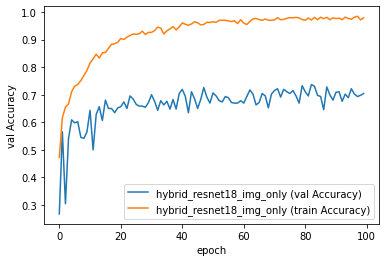

In [60]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_hybrid_img_only, label=label_img_only + ' (val Accuracy)')
sns.lineplot(x='epoch', y='train Accuracy', data=results_hybrid_img_only, label=label_img_only + ' (train Accuracy)')

In [61]:
results_hybrid_img_only

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,726.766831,1.274703,2.346170,0.472489,0.267391
1,1,960.019146,0.930488,1.302289,0.616249,0.565217
2,2,1193.428890,0.822416,1.583920,0.655116,0.304348
3,3,1426.328461,0.781747,1.045916,0.666589,0.541304
4,4,1658.839693,0.687764,1.058017,0.710606,0.608696
...,...,...,...,...,...,...
95,95,22722.456071,0.083681,1.630600,0.973777,0.721739
96,96,22954.020803,0.060580,1.506832,0.981503,0.702174
97,97,23185.943946,0.057227,1.494801,0.984781,0.693478
98,98,23418.067695,0.093423,1.365535,0.971435,0.697826


**Load the saved best model:**

In [62]:
best_model_state = torch.load(best_model_state_file_img_only)

best_model_img_only = ImageTabularHybridModel(hijacked_cnn_model_name=HIJACKED_MODEL, hybrid_status=HYBRID_STATUS_IMG_ONLY)

best_model_img_only.load_state_dict(best_model_state['model_state_dict'])

best_epoch = best_model_state['epoch']
print('best_epoch:', best_epoch)

best_val_score = best_model_state['best_score']
print('best_val_score:', best_val_score)

best_epoch: 82
best_val_score: 0.7369565217391304


In [63]:
hybrid_model_img_only = best_model_img_only

In [64]:
hybrid_model_img_only.to(device)

ImageTabularHybridModel(
  (hijacked_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

**Visualize Confusion Matrix:**

  0%|          | 0/4 [00:00<?, ?it/s]

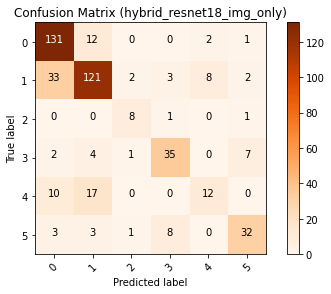

In [65]:
cm_hybrid_model_img_only, accuracy_score_hybrid_model_img_only, cls_report_hybrid_model_img_only = construct_and_plot_confusion_matrix(hybrid_model_img_only, 
                                                                                                                                    class_idx.values(), 
                                                                                                                                    test_loader, 
                                                                                                                                    label_img_only)

**Accuracy Score:**

In [66]:
print('accuracy_score_hybrid_model_img_only:', accuracy_score_hybrid_model_img_only)

accuracy_score_hybrid_model_img_only: 0.7369565217391304


**Classification Report:**

In [67]:
print(cls_report_img_only_title + ':\n\n', cls_report_hybrid_model_img_only)

Classification Report of hybrid model ResNet18(img only):

               precision    recall  f1-score   support

           0       0.73      0.90      0.81       146
           1       0.77      0.72      0.74       169
           2       0.67      0.80      0.73        10
           3       0.74      0.71      0.73        49
           4       0.55      0.31      0.39        39
           5       0.74      0.68      0.71        47

    accuracy                           0.74       460
   macro avg       0.70      0.69      0.68       460
weighted avg       0.73      0.74      0.73       460



**Instantiate the Hybrid Model for training tabular data only:**

In [68]:
hybrid_model_tab_only = ImageTabularHybridModel(hijacked_cnn_model_name=HIJACKED_MODEL, hybrid_status=HYBRID_STATUS_TAB_ONLY)

**Print the Model:**

In [69]:
hybrid_model_tab_only

ImageTabularHybridModel(
  (tabular_linear_relu_stack): Sequential(
    (0): Linear(in_features=69, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=128, out_features=6, bias=True)
)

**Loss Function:**

In [70]:
loss = nn.CrossEntropyLoss()

**Specifiy checkpoint file:**

In [71]:
checkpoint_hybrid_tab_only = os.path.join(saved_file_path, TAB_ONLY_CHECK_POINT_FILE)

best_model_state_file_tab_only = os.path.join(saved_file_path, TAB_ONLY_BEST_STATE_FILE)

**Train the model:**

In [72]:
results_hybrid_tab_only = train_dl_model(hybrid_model_tab_only, loss, train_loader, 
                                                              epochs=EPOCHS, device=device, val_loader=test_loader, 
                                                              checkpoint_file=checkpoint_hybrid_tab_only,
                                                              best_model_state_file=best_model_state_file_tab_only,
                                                              score_funcs={'Accuracy': accuracy_score})

Loading checkpoint file: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/Deep_Learning/Saved_Files/hybrid_resnet18_tab_only_final_checkpoint2.pt
last_epoch:  99
results: {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'total time': [227.18307423591614, 454.1663992404938, 680.5380113124847, 907.2708179950714, 1133.9242475032806, 1360.5097696781158, 1587.8712611198425, 1814.4824059009552, 2041.4074709415436, 2268.3929409980774, 2494.7153062820435, 2720.328104496002, 2946.5622675418854, 3173.1375086307526, 3398.778467655182, 3624.7296919822693, 3850.7657482624054, 4076.4455473423004, 4302.845048427582, 4528.8211188316345, 4755.

Epoch: 0it [00:00, ?it/s]

**Plot validation accuracy for each epoch:**

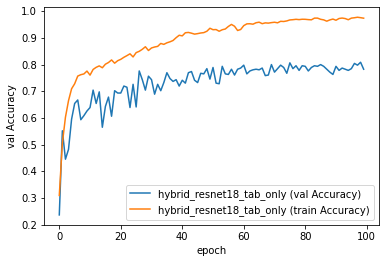

In [73]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_hybrid_tab_only, label=label_tab_only + ' (val Accuracy)')
sns.lineplot(x='epoch', y='train Accuracy', data=results_hybrid_tab_only, label=label_tab_only + ' (train Accuracy)')

In [74]:
results_hybrid_tab_only

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,227.183074,1.656897,1.573383,0.309998,0.236957
1,1,454.166399,1.203998,1.251398,0.506205,0.552174
2,2,680.538011,0.976744,1.254050,0.602669,0.445652
3,3,907.270818,0.824862,1.165497,0.664950,0.482609
4,4,1133.924248,0.733585,0.990455,0.709436,0.595652
...,...,...,...,...,...,...
95,95,21651.724088,0.067313,1.340761,0.974011,0.784783
96,96,21878.895951,0.062836,1.542677,0.975416,0.804348
97,97,22106.485105,0.061975,1.400176,0.977289,0.797826
98,98,22332.664381,0.061322,1.518038,0.975650,0.808696


**Load the saved best model:**

In [75]:
best_model_state = torch.load(best_model_state_file_tab_only)

best_model_tab_only = ImageTabularHybridModel(hijacked_cnn_model_name=HIJACKED_MODEL, hybrid_status=HYBRID_STATUS_TAB_ONLY)

best_model_tab_only.load_state_dict(best_model_state['model_state_dict'])

best_epoch = best_model_state['epoch']
print('best_epoch:', best_epoch)

best_val_score = best_model_state['best_score']
print('best_val_score:', best_val_score)

best_epoch: 98
best_val_score: 0.808695652173913


In [76]:
hybrid_model_tab_only = best_model_tab_only

In [77]:
hybrid_model_tab_only.to(device)

ImageTabularHybridModel(
  (tabular_linear_relu_stack): Sequential(
    (0): Linear(in_features=69, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=128, out_features=6, bias=True)
)

**Visualize Confusion Matrix:**

  0%|          | 0/4 [00:00<?, ?it/s]

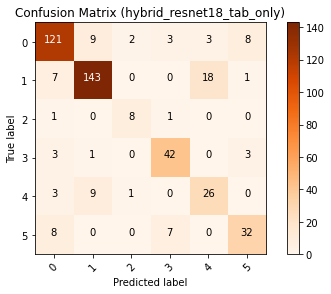

In [78]:
cm_hybrid_model_tab_only, accuracy_score_hybrid_model_tab_only, cls_report_hybrid_model_tab_only = construct_and_plot_confusion_matrix(hybrid_model_tab_only, 
                                                                                                                                    class_idx.values(), 
                                                                                                                                    test_loader, 
                                                                                                                                    label_tab_only)
                                                                                                                                 

**Accuracy Score:**

In [79]:
print('accuracy_score_hybrid_model_tab_only:', accuracy_score_hybrid_model_tab_only)

accuracy_score_hybrid_model_tab_only: 0.808695652173913



**Classification Report:**

In [80]:
print(cls_report_tab_only_title + ':\n\n', cls_report_hybrid_model_tab_only)

Classification Report of hybrid model ResNet18(tab only):

               precision    recall  f1-score   support

           0       0.85      0.83      0.84       146
           1       0.88      0.85      0.86       169
           2       0.73      0.80      0.76        10
           3       0.79      0.86      0.82        49
           4       0.55      0.67      0.60        39
           5       0.73      0.68      0.70        47

    accuracy                           0.81       460
   macro avg       0.75      0.78      0.77       460
weighted avg       0.81      0.81      0.81       460



**Instantiate the Hybrid Model for training both image and tabular:**

In [81]:
hybrid_model_img_tab = ImageTabularHybridModel(hijacked_cnn_model_name=HIJACKED_MODEL, hybrid_status=HYBRID_STATUS_IMG_TAB)

**Print the Model:**

In [82]:
hybrid_model_img_tab

ImageTabularHybridModel(
  (hijacked_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

**Loss Function:**

In [83]:
loss = nn.CrossEntropyLoss()

**Specifiy checkpoint file:**

In [84]:
checkpoint_hybrid_img_tab = os.path.join(saved_file_path, IMG_TAB_CHECK_POINT_FILE )

best_model_state_file_img_tab = os.path.join(saved_file_path, IMG_TAB_BEST_STATE_FILE)

**Train the model:**

In [85]:
results_hybrid_img_tab = train_dl_model(hybrid_model_img_tab, loss, train_loader, 
                                                              epochs=EPOCHS, device=device, val_loader=test_loader, 
                                                              checkpoint_file=checkpoint_hybrid_img_tab,
                                                              best_model_state_file=best_model_state_file_img_tab,
                                                              score_funcs={'Accuracy': accuracy_score})

Loading checkpoint file: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/Deep_Learning/Saved_Files/hybrid_resnet18_img_tab_final_checkpoint2.pt
last_epoch:  99
results: {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'total time': [231.97559428215027, 464.832083940506, 698.4294373989105, 931.7695255279541, 1165.3424615859985, 1398.1142838001251, 1630.7720274925232, 1863.4512150287628, 2095.5459220409393, 2328.2823338508606, 2561.6778542995453, 2795.477576971054, 3028.8220121860504, 3261.8892340660095, 3494.958704471588, 3726.632982969284, 3959.067417860031, 4192.501800537109, 4424.43656206131, 4657.350868463516, 4890.6916177

Epoch: 0it [00:00, ?it/s]

**Plot validation accuracy for each epoch:**

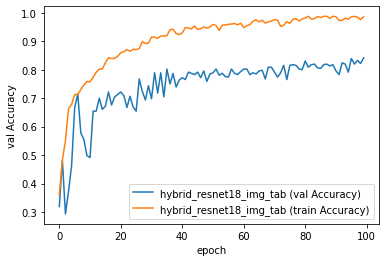

In [86]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_hybrid_img_tab, label=label_img_tab + ' (val Accuracy)')
sns.lineplot(x='epoch', y='train Accuracy', data=results_hybrid_img_tab, label=label_img_tab + ' (train Accuracy)')

In [87]:
results_hybrid_img_tab

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,231.975594,1.485095,2.124080,0.361274,0.319565
1,1,464.832084,1.157694,1.675395,0.481620,0.482609
2,2,698.429437,1.040599,1.455806,0.550925,0.293478
3,3,931.769526,0.759415,1.167065,0.663077,0.371739
4,4,1165.342462,0.705192,0.926260,0.677827,0.463043
...,...,...,...,...,...,...
95,95,22599.123010,0.044880,0.989154,0.985249,0.839130
96,96,22806.666022,0.033691,1.068258,0.987122,0.819565
97,97,23013.863039,0.044137,1.166409,0.984313,0.832609
98,98,23220.998302,0.070712,0.902851,0.975650,0.821739


**Load the saved best model:**

In [88]:
best_model_state = torch.load(best_model_state_file_img_tab)

best_model_img_tab = ImageTabularHybridModel(hijacked_cnn_model_name=HIJACKED_MODEL, hybrid_status=HYBRID_STATUS_IMG_TAB)

best_model_img_tab.load_state_dict(best_model_state['model_state_dict'])

best_epoch = best_model_state['epoch']
print('best_epoch:', best_epoch)

best_val_score = best_model_state['best_score']
print('best_val_score:', best_val_score)

best_epoch: 99
best_val_score: 0.841304347826087


In [89]:
hybrid_model_img_tab = best_model_img_tab

In [90]:
hybrid_model_img_tab.to(device)

ImageTabularHybridModel(
  (hijacked_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

**Visualize Confusion Matrix:**

  0%|          | 0/4 [00:00<?, ?it/s]

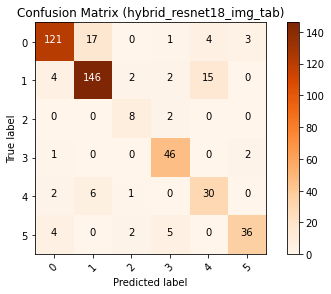

In [91]:
cm_hybrid_model_img_tab, accuracy_score_hybrid_model_img_tab, cls_report_hybrid_model_img_tab = construct_and_plot_confusion_matrix(hybrid_model_img_tab, 
                                                                                                                                    class_idx.values(), 
                                                                                                                                    test_loader, 
                                                                                                                                    label_img_tab)
                                                                                                                                 


**Accuracy Score:**

In [92]:
print('accuracy_score_hybrid_model_img_tab:', accuracy_score_hybrid_model_img_tab)

accuracy_score_hybrid_model_img_tab: 0.841304347826087


**Classification Report:**

In [93]:
print(cls_report_img_tab_title+':\n\n', cls_report_hybrid_model_img_tab)

Classification Report of hybrid model ResNet18(img-tab combined):

               precision    recall  f1-score   support

           0       0.92      0.83      0.87       146
           1       0.86      0.86      0.86       169
           2       0.62      0.80      0.70        10
           3       0.82      0.94      0.88        49
           4       0.61      0.77      0.68        39
           5       0.88      0.77      0.82        47

    accuracy                           0.84       460
   macro avg       0.78      0.83      0.80       460
weighted avg       0.85      0.84      0.84       460



**Compare accuracy results among trained by "Image Only", "Tabular only", and "Image-Tabular Combined" :**

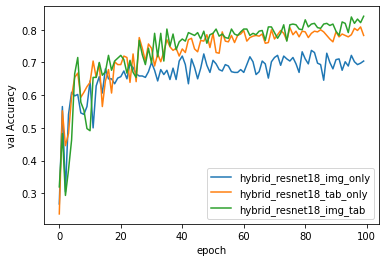

In [94]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_hybrid_img_only, label=label_img_only)
sns.lineplot(x='epoch', y='val Accuracy', data=results_hybrid_tab_only, label=label_tab_only)
sns.lineplot(x='epoch', y='val Accuracy', data=results_hybrid_img_tab, label=label_img_tab)

**Find the epoch number that yeids the highest validation score:**

**Image Only:**

In [95]:
result_df_img = results_hybrid_img_only

In [96]:
result_df_img.loc[result_df_img['val Accuracy'].idxmax()]

epoch                82.000000
total time        19702.079193
train loss            0.078990
val loss              1.432959
train Accuracy        0.970967
val Accuracy          0.736957
Name: 82, dtype: float64

In [97]:
best_epoch = result_df_img.loc[result_df_img['val Accuracy'].idxmax()]['epoch']
best_accuracy = result_df_img.loc[result_df_img['val Accuracy'].idxmax()]['val Accuracy']

print('For "image-only", the best accuracy score', best_accuracy, 'is at epoch:', np.int(best_epoch))

For "image-only", the best accuracy score 0.7369565217391304 is at epoch: 82


**Tabular Only:**

In [98]:
result_df_tab = results_hybrid_tab_only

In [99]:
result_df_tab.loc[result_df_tab['val Accuracy'].idxmax()]

epoch                98.000000
total time        22332.664381
train loss            0.061322
val loss              1.518038
train Accuracy        0.975650
val Accuracy          0.808696
Name: 98, dtype: float64

In [100]:
best_epoch = result_df_tab.loc[result_df_tab['val Accuracy'].idxmax()]['epoch']
best_accuracy = result_df_tab.loc[result_df_tab['val Accuracy'].idxmax()]['val Accuracy']

print('For "tabular-only", the best accuracy score', best_accuracy, 'is at epoch:', np.int(best_epoch))

For "tabular-only", the best accuracy score 0.808695652173913 is at epoch: 98


**Image-Tabular Combined:**

In [101]:
result_df_comb = results_hybrid_img_tab

In [102]:
result_df_comb.loc[result_df_comb['val Accuracy'].idxmax()]

epoch                99.000000
total time        23428.157341
train loss            0.042682
val loss              1.275653
train Accuracy        0.985952
val Accuracy          0.841304
Name: 99, dtype: float64

In [103]:
best_epoch = result_df_comb.loc[result_df_comb['val Accuracy'].idxmax()]['epoch']
best_accuracy = result_df_comb.loc[result_df_comb['val Accuracy'].idxmax()]['val Accuracy']

print('For image-tabular combined, the best accuracy score', best_accuracy, 'is at epoch:', np.int(best_epoch))

For image-tabular combined, the best accuracy score 0.841304347826087 is at epoch: 99


#### **------------------------------------------------------------------------------------------------------------------------**